# CIC IDS 2017

# 1. Import libraries

In [27]:
import os
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.callback import EarlyStopping

In [2]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/MachineLearningCSV.zip
data/CIC_IDS_2017/GeneratedLabelledFlows.md5
data/CIC_IDS_2017/GeneratedLabelledFlows.zip
data/CIC_IDS_2017/download_dataset
data/CIC_IDS_2017/MachineLearningCSV.md5
data/CIC_IDS_2017/TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_20

# 2. Load data

In [3]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')

In [4]:
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [5]:
def missing_values(df):
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    print(df.name)
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    with open(f"{df.name}_table.txt", 'w') as f:
        f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    print(f"Table saved as {df.name}_table.txt")

In [6]:
datasets = ['monday', 'tuesday', 'wednesday', 'thursday_morning', 'thursday_afternoon', 'friday_ddos', 'friday_pcap', 'friday_morning']
for dataset in datasets:
    if dataset == 'monday':
        missing_values(monday)
    elif dataset == 'tuesday':
        missing_values(tuesday)
    elif dataset == 'wednesday':
        missing_values(wednesday)
    elif dataset == 'thursday_morning':
        missing_values(thursday_morning)
    elif dataset == 'thursday_afternoon':
        missing_values(thursday_afternoon)
    elif dataset == 'friday_ddos':
        missing_values(friday_ddos)
    elif dataset == 'friday_pcap':
        missing_values(friday_pcap)
    elif dataset == 'friday_morning':
        missing_values(friday_morning)

Monday
+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |   529918   |       0        |        0.00%        |
|         Flow Duration        |   529918   |       0        |        0.00%        |
|       Total Fwd Packets      |   529918   |       0        |        0.00%        |
|    Total Backward Packets    |   529918   |       0        |        0.00%        |
| Total Length of Fwd Packets  |   529918   |       0        |        0.00%        |
|  Total Length of Bwd Packets |   529918   |       0        |        0.00%        |
|     Fwd Packet Length Max    |   529918   |       0        |        0.00%        |
|     Fwd Packet Length Min    |   529918   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |   529918   |       0     

Merge all datasets to one dataframe

In [7]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [8]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [10]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [12]:
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [13]:
data.isna().any()[data.isna().any() == True]

Flow Bytes/s    True
dtype: bool

In [14]:
data = data.replace([-np.inf, np.inf], np.nan)

In [15]:
data[data.isna().any(axis=1)==True]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
33,1029,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
77,49478,0,2,0,37,0,31,6,18.5,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
80,49478,0,2,0,37,0,31,6,18.5,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
92,49488,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
97,49488,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278979,51396,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
279129,49884,0,2,0,14,0,14,0,7.0,9.899495,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
281744,443,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
282054,443,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [16]:
data.dropna(inplace=True)

In [17]:
data[data.isna().any(axis=1)==True]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


# 3. Exploratory Data Analysis

In [134]:
label = data[' Label'].value_counts().index.tolist()
count = data[' Label'].value_counts()

In [135]:
label

['BENIGN',
 'DoS Hulk',
 'PortScan',
 'DDoS',
 'DoS GoldenEye',
 'FTP-Patator',
 'SSH-Patator',
 'DoS slowloris',
 'DoS Slowhttptest',
 'Bot',
 'Web Attack � Brute Force',
 'Web Attack � XSS',
 'Infiltration',
 'Web Attack � Sql Injection',
 'Heartbleed']

In [136]:
count

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

## 3.1 Histogram

In [137]:
def hist_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(15,15))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')

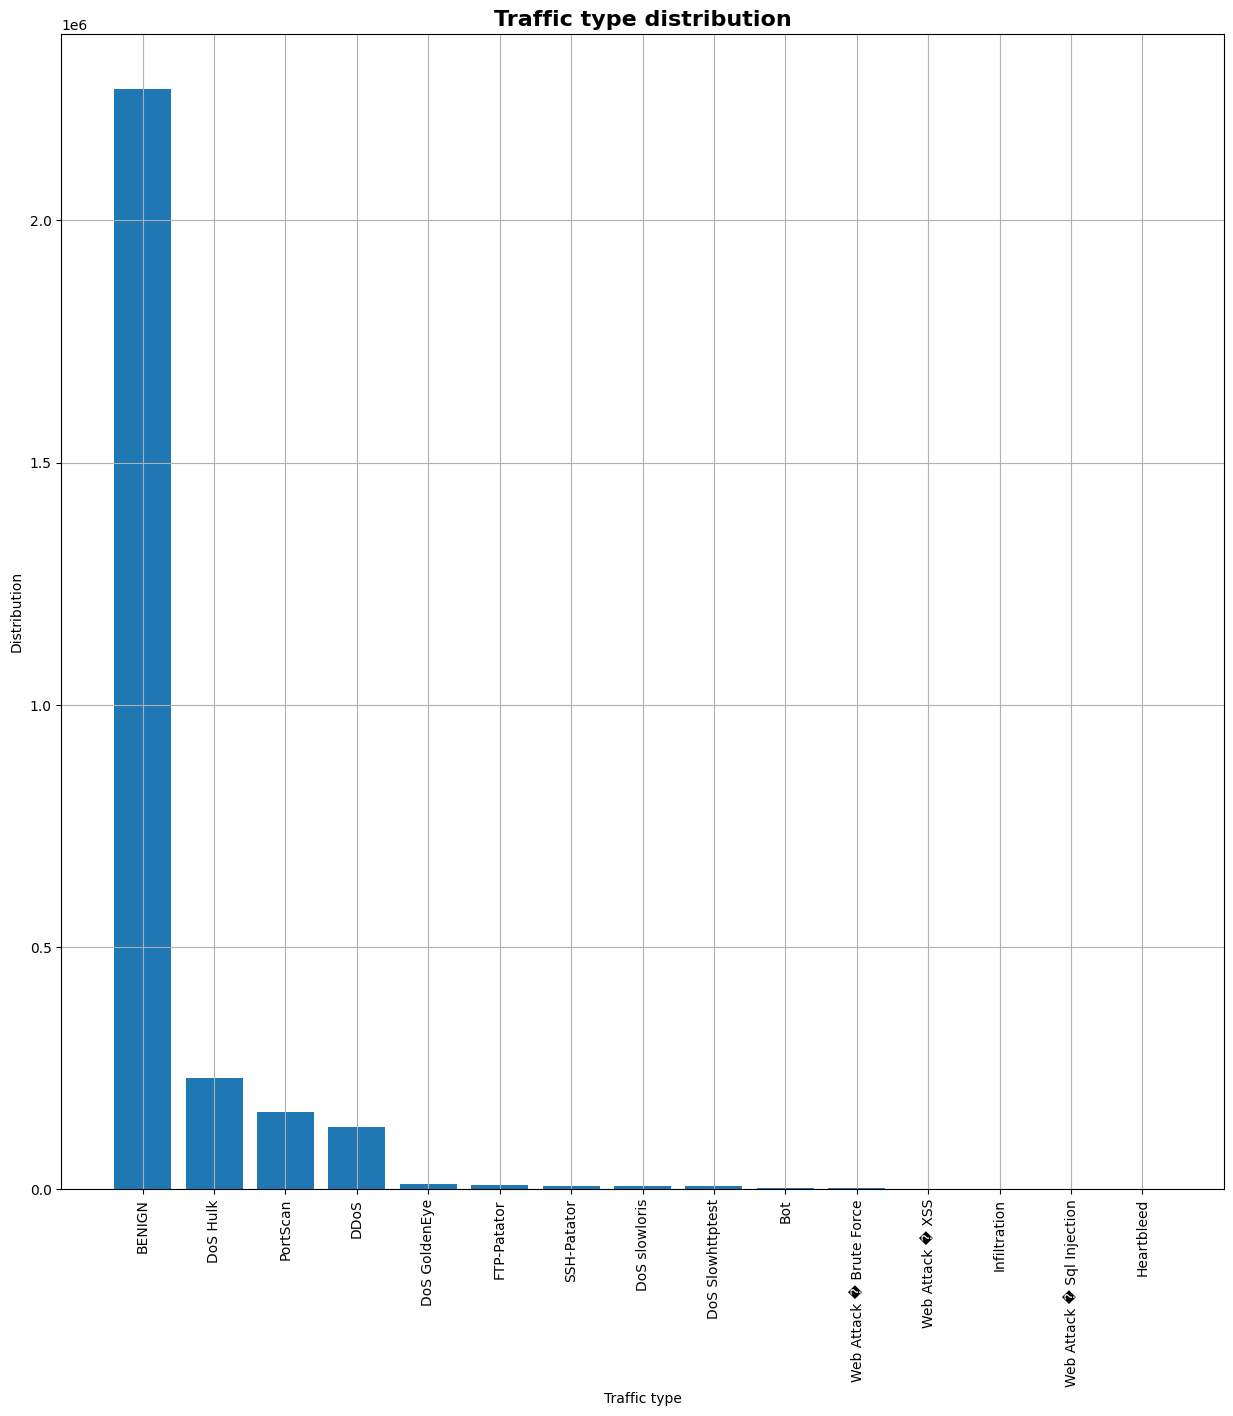

In [138]:
hist_plot(label, count)

In [157]:
def attack_plot(label, count):
    _dict = {}
    label = [x for x in label if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(15,15))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')

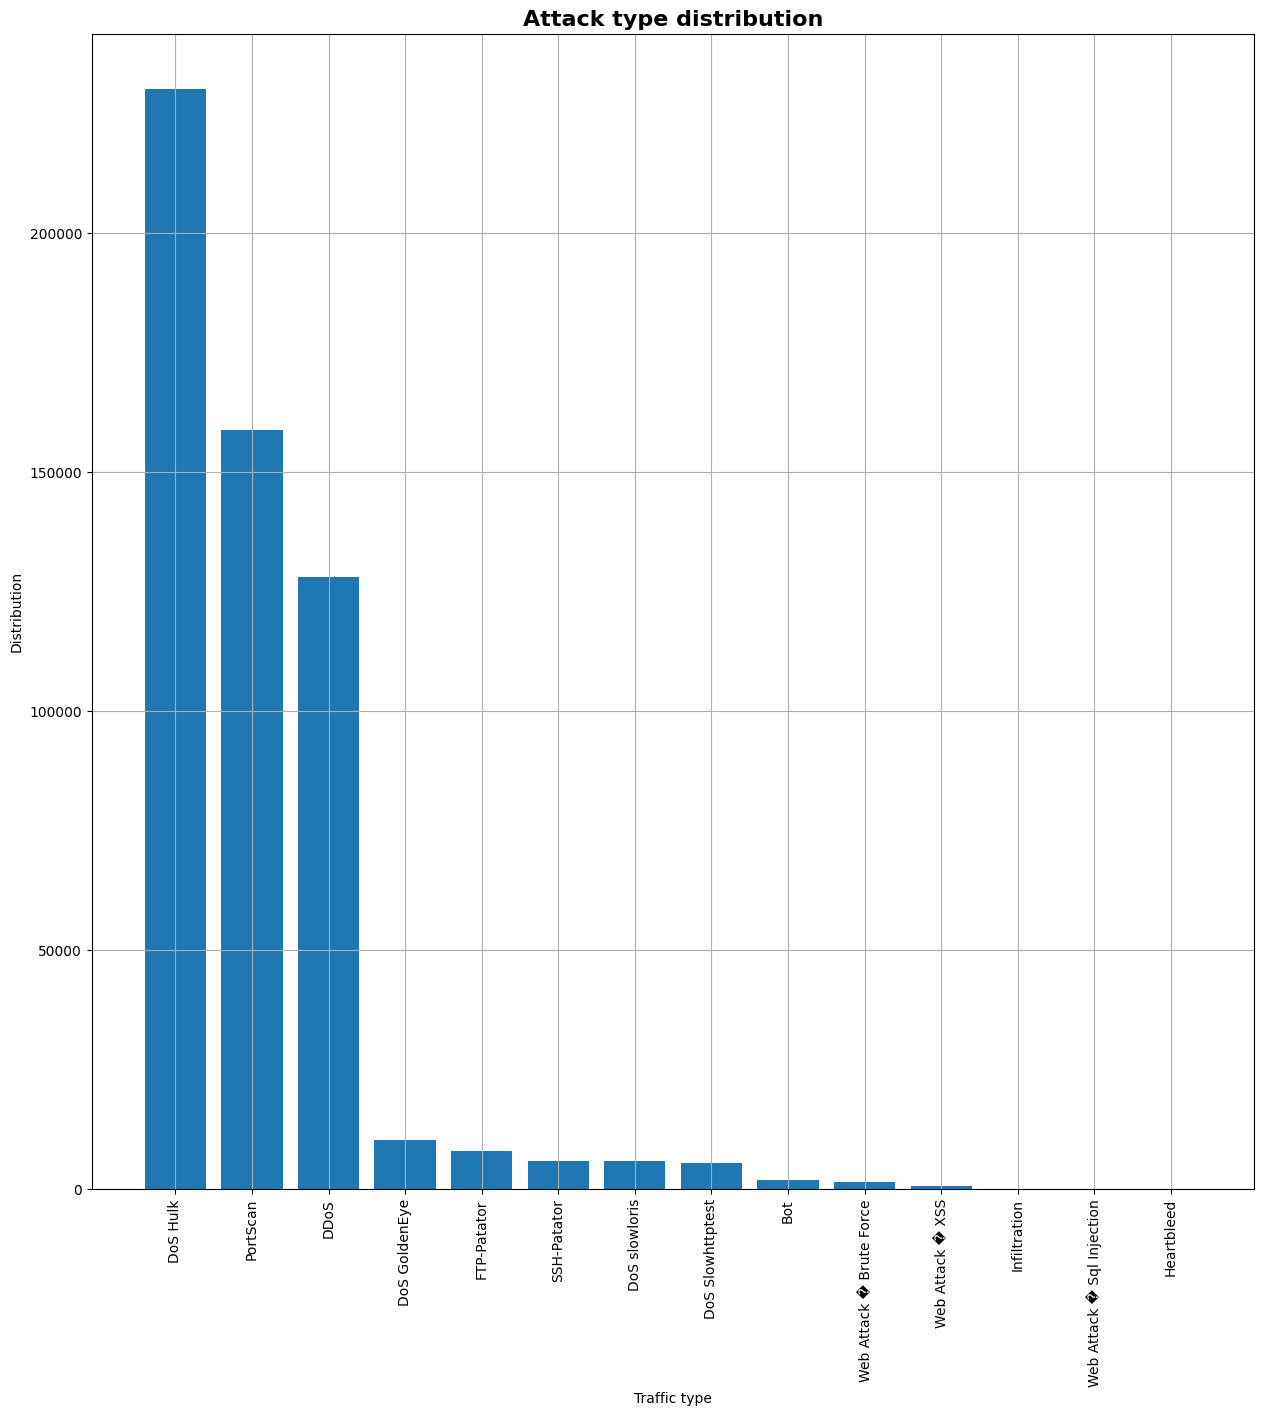

In [158]:
attack_plot(label, count)

## 3.2 Correlation matrix

In [18]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [161]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [162]:
y

0         BENIGN
1         BENIGN
2         BENIGN
3         BENIGN
4         BENIGN
           ...  
286462    BENIGN
286463    BENIGN
286464    BENIGN
286465    BENIGN
286466    BENIGN
Name:  Label, Length: 2827876, dtype: object

In [163]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 286466
Data columns (total 78 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [164]:
y.info()

<class 'pandas.core.series.Series'>
Index: 2827876 entries, 0 to 286466
Series name:  Label
Non-Null Count    Dtype 
--------------    ----- 
2827876 non-null  object
dtypes: object(1)
memory usage: 43.1+ MB


In [165]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [19]:
%%time
corr_matrix = X.corr()

CPU times: user 1min 25s, sys: 1.96 s, total: 1min 26s
Wall time: 1min 35s


Drop all rows and columns with NaN's

In [20]:
corr_matrix = corr_matrix.dropna(axis=0, how='all')
irrelevant_features = corr_matrix.columns[corr_matrix.isna().any()].tolist()
corr_matrix = corr_matrix.dropna(axis=1, how='all')

In [21]:
irrelevant_features

[' Bwd PSH Flags',
 ' Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [209]:
corr_matrix

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Destination Port,1.000000,-0.151610,-0.004234,-0.003945,0.011185,-0.003081,0.098175,-0.045330,0.140511,0.129116,...,-0.003225,0.000896,-0.035530,-0.043705,-0.051831,-0.023163,-0.112515,0.010469,-0.108107,-0.114553
Flow Duration,-0.151610,1.000000,0.020854,0.019667,0.065439,0.016185,0.273221,-0.105380,0.143584,0.234361,...,0.015940,-0.001356,0.189263,0.241038,0.294000,0.121138,0.768001,0.243131,0.779494,0.738292
Total Fwd Packets,-0.004234,0.020854,1.000000,0.999070,0.365508,0.996993,0.009355,-0.002992,0.000029,0.001401,...,0.887387,-0.000184,0.039936,0.008328,0.030457,0.041282,0.001816,0.000808,0.001902,0.001667
Total Backward Packets,-0.003945,0.019667,0.999070,1.000000,0.359451,0.994429,0.009036,-0.002603,-0.000336,0.001024,...,0.882566,0.000018,0.038962,0.006436,0.028601,0.041277,0.001422,0.000491,0.001452,0.001326
Total Length of Fwd Packets,0.011185,0.065439,0.365508,0.359451,1.000000,0.353762,0.197022,-0.000292,0.185258,0.159779,...,0.407448,-0.001209,0.101078,0.103321,0.126486,0.068319,0.022642,0.027058,0.026061,0.018617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Active Min,-0.023163,0.121138,0.041282,0.041277,0.068319,0.039068,0.105617,-0.025944,0.081146,0.094143,...,0.031394,-0.006834,0.905861,0.033863,0.584497,1.000000,0.118105,0.038292,0.122623,0.112853
Idle Mean,-0.112515,0.768001,0.001816,0.001422,0.022642,0.000806,0.181053,-0.071417,0.127872,0.183071,...,0.000835,-0.000875,0.120135,0.036516,0.088858,0.118105,1.000000,0.150219,0.990386,0.990214
Idle Std,0.010469,0.243131,0.000808,0.000491,0.027058,0.000104,0.178069,-0.029987,0.178442,0.191258,...,0.000720,-0.003719,0.070573,0.081424,0.069987,0.038292,0.150219,1.000000,0.283310,0.011572
Idle Max,-0.108107,0.779494,0.001902,0.001452,0.026061,0.000795,0.199478,-0.073534,0.148317,0.203237,...,0.000926,-0.001406,0.132664,0.055266,0.102770,0.122623,0.990386,0.283310,1.000000,0.961807


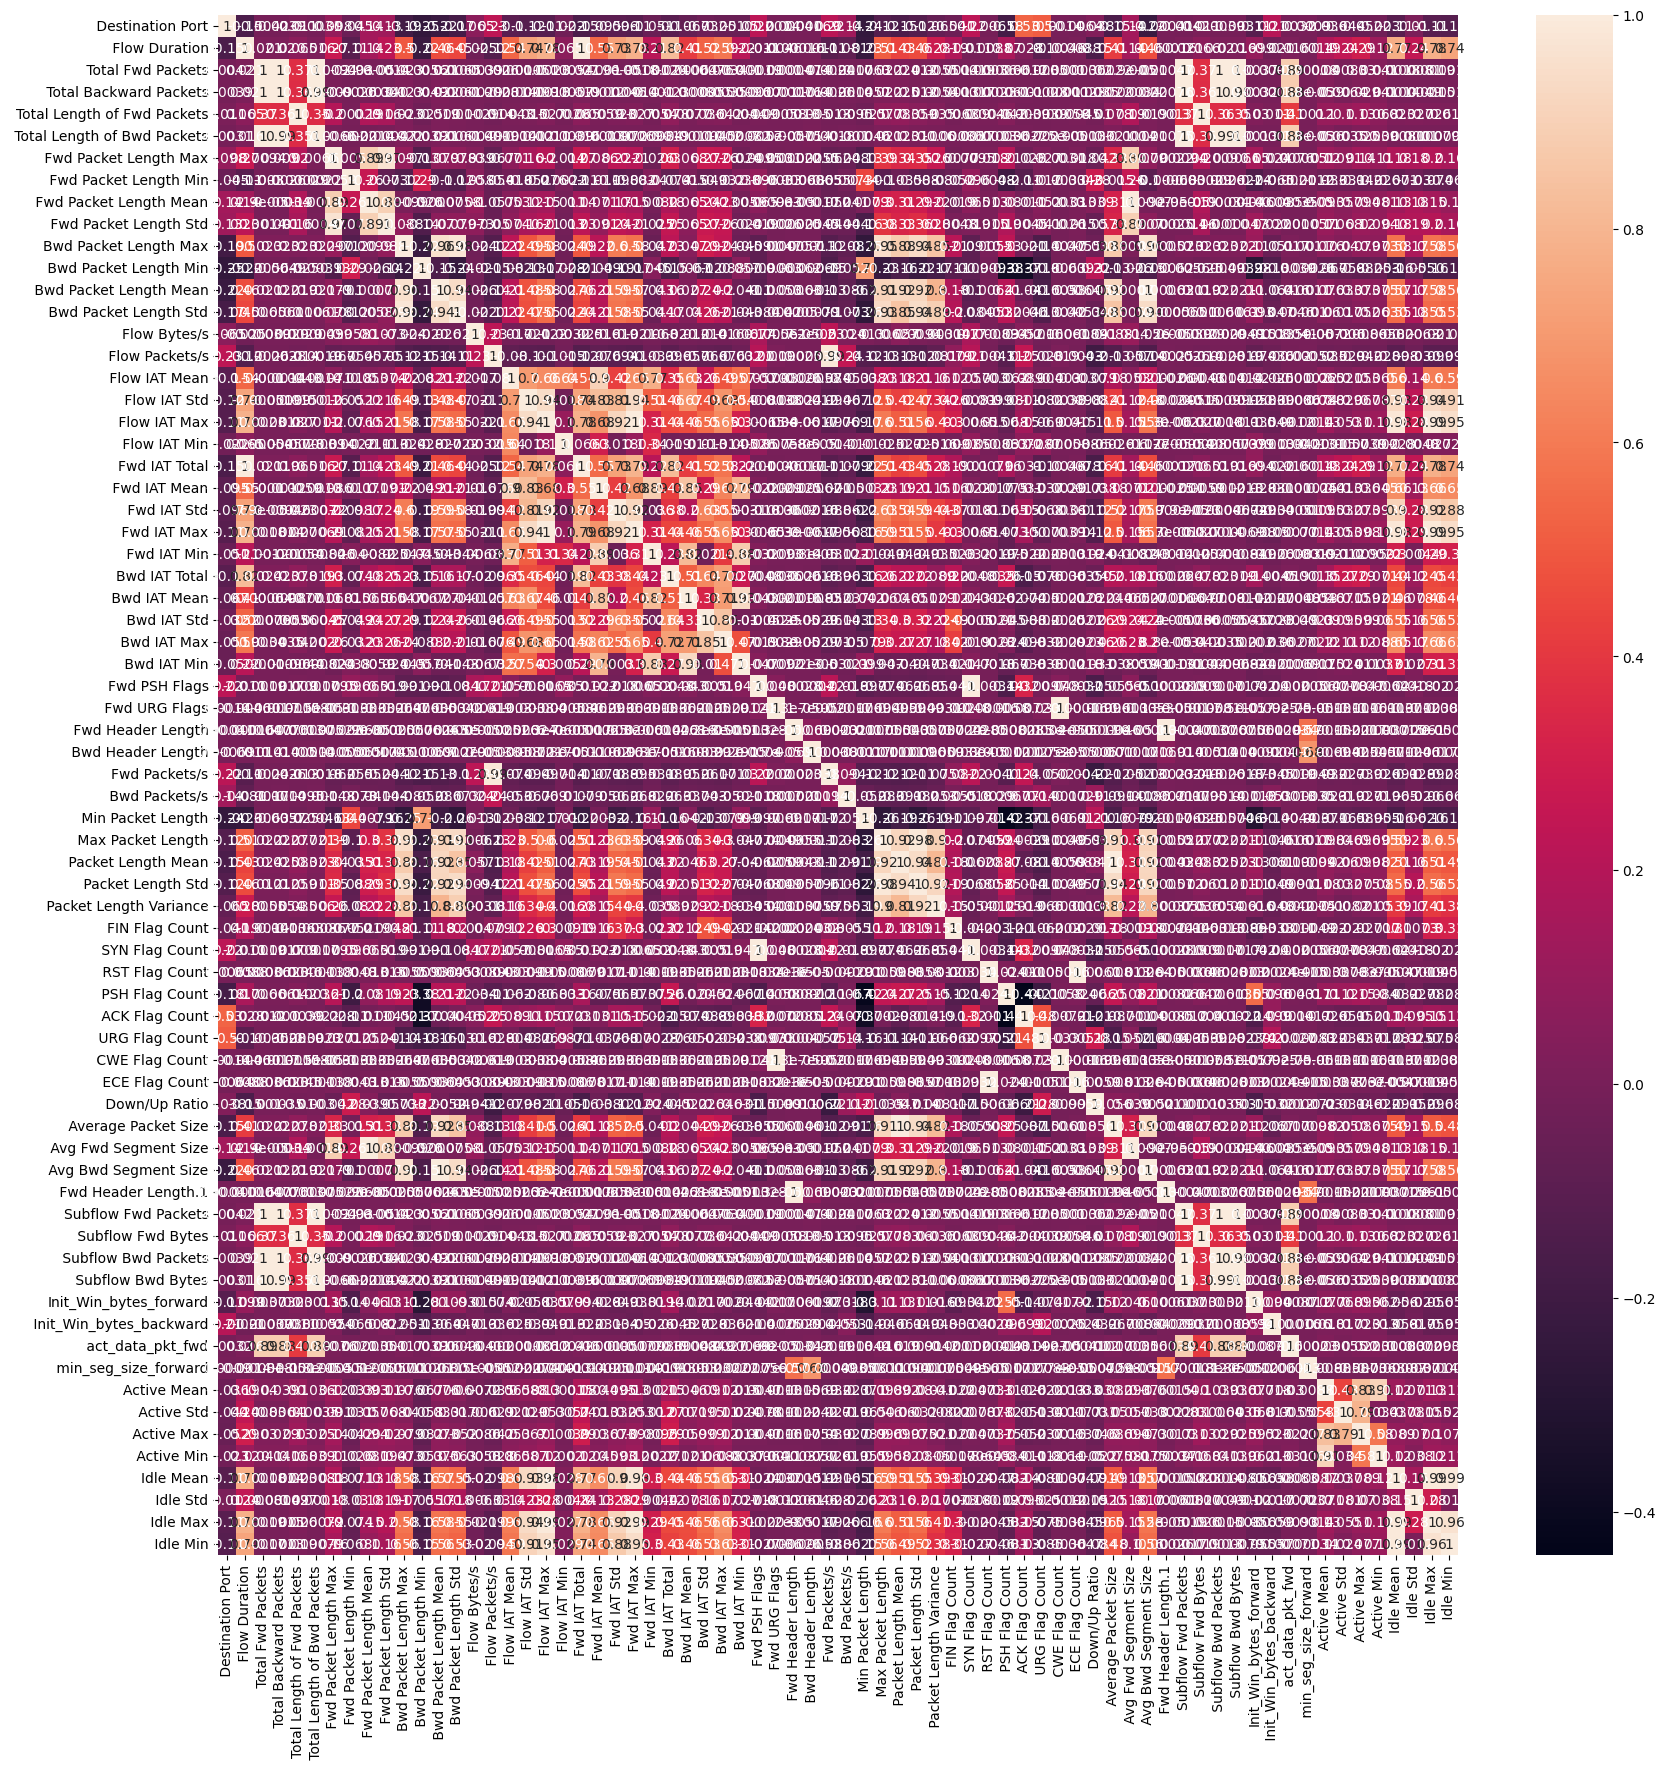

CPU times: user 9.47 s, sys: 242 ms, total: 9.71 s
Wall time: 9.71 s


In [210]:
%%time
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# 3. Feature Engineering

## 3.1 Drop Irrelevant Features

In [22]:
# Drop irrelevant features
X = X.drop(irrelevant_features, axis=1)

In [23]:
X

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,30,20,0.0,0.0,0,0,0.0,0.0,0,0
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,47,20,0.0,0.0,0,0,0.0,0.0,0,0
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0


## 3.2 Drop Correlated Featres

Drop highly correlated features

In [24]:
def remove_correlated(data, corr_matrix, threshold):
    iterations = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iterations:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    data = data.drop(columns=drops)
    print(f"Removed columns: {drops}")
    return data

In [25]:
X = remove_correlated(X, corr_matrix, 0.85)

Removed columns: {' Max Packet Length', ' Bwd Packet Length Mean', ' Flow IAT Max', ' Avg Fwd Segment Size', ' SYN Flag Count', ' Subflow Fwd Bytes', ' Total Length of Bwd Packets', ' Packet Length Variance', ' Bwd Packet Length Std', 'Fwd IAT Total', ' Packet Length Mean', ' Avg Bwd Segment Size', ' act_data_pkt_fwd', ' Fwd IAT Max', 'Fwd Packets/s', ' Total Backward Packets', ' Average Packet Size', 'Subflow Fwd Packets', ' Fwd IAT Min', ' Bwd IAT Min', ' Fwd Header Length.1', ' Fwd IAT Std', ' Subflow Bwd Bytes', ' Idle Min', ' Fwd IAT Mean', ' Active Min', ' CWE Flag Count', ' ECE Flag Count', ' Subflow Bwd Packets', ' Idle Max', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Idle Mean', ' Packet Length Std'}


In [26]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,...,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Active Max,Idle Std
0,49188,4,2,12,6,6,0,0,3000000.0,5.000000e+05,...,1,1,0,329,-1,20,0.0,0.0,0,0.0
1,49188,1,2,12,6,6,0,0,12000000.0,2.000000e+06,...,1,1,0,329,-1,20,0.0,0.0,0,0.0
2,49188,1,2,12,6,6,0,0,12000000.0,2.000000e+06,...,1,1,0,329,-1,20,0.0,0.0,0,0.0
3,49188,1,2,12,6,6,0,0,12000000.0,2.000000e+06,...,1,1,0,329,-1,20,0.0,0.0,0,0.0
4,49486,3,2,12,6,6,0,0,4000000.0,6.666667e+05,...,1,1,0,245,-1,20,0.0,0.0,0,0.0


## 3.3 Label Encoding

Encode target variable

In [27]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
y = le.fit_transform(y)

In [31]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

## 3.4 Data Scaling

In [32]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10461905,
        -0.14940357, -0.10951643]])

## 3.5 Save Data

In [36]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 3.6 Load Data

In [8]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [9]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10461905,
        -0.14940357, -0.10951643]])

In [10]:
y

array([0, 0, 0, ..., 0, 0, 0])

# 4. Create Models

## 4.1 Evaluation metrics

In [21]:
def accuracy(y_val, y_preds, count=0):
    for x in range(len(y_val)):
        if y_val[x] == y_preds[x]:
            count += 1
    return count / len(y_preds)

## 4.2 Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2403694, 36), (2403694,), (424182, 36), (424182,))

## 4.3 XGBoost Classifier

In [32]:
%%time
def objective(trial, data=X, target=y, average=0):
    param = {
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [300]),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['merror']),
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
        'device' : trial.suggest_categorical('device', ['cuda']),
        'tree_method': trial.suggest_categorical('tree_method', ['hist']),  # this parameter means using the GPU when training our model to speedup the training process
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 5),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'eta': trial.suggest_float('subsample', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 255, 8192),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('lambda', 1.0, 100.0),
        'reg_alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
    }

    # Count folds
    c = 1
    
    # Instantiate a cross-validator
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(data, target):
        X_train, y_train = data[train_idx], target[train_idx]
        x_val, y_val = data[val_idx], target[val_idx]
        xgbr_model = XGBClassifier(**param)
        xgbr_model.fit(X_train, y_train, eval_set=[(x_val,y_val)],verbose=1,callbacks=[EarlyStopping(rounds = 300,save_best=True)])
        y_preds = xgbr_model.predict(x_val)
        accuracy = accuracy(y_val, y_preds)
        average += accuracy
        c += 1
    gc.collect()
    return average/(c-1)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

[I 2024-05-06 20:26:06,361] A new study created in memory with name: no-name-955db12d-4edd-4267-adb2-e37ed77bf2da
<timed exec>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "subsample"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.1, 'high': 1.0, 'log': False}
  warnings.warn(
<timed exec>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

[0]	validation_0-merror:0.02389
[1]	validation_0-merror:0.01670
[2]	validation_0-merror:0.01666
[3]	validation_0-merror:0.01671
[4]	validation_0-merror:0.01607
[5]	validation_0-merror:0.01579
[6]	validation_0-merror:0.01729
[7]	validation_0-merror:0.01682
[8]	validation_0-merror:0.01740
[9]	validation_0-merror:0.01567
[10]	validation_0-merror:0.01509
[11]	validation_0-merror:0.01483
[12]	validation_0-merror:0.01462
[13]	validation_0-merror:0.01440
[14]	validation_0-merror:0.01389
[15]	validation_0-merror:0.01346
[16]	validation_0-merror:0.01323
[17]	validation_0-merror:0.01307
[18]	validation_0-merror:0.01310
[19]	validation_0-merror:0.00878
[20]	validation_0-merror:0.00866
[21]	validation_0-merror:0.00871
[22]	validation_0-merror:0.00694
[23]	validation_0-merror:0.00675
[24]	validation_0-merror:0.00661
[25]	validation_0-merror:0.00654
[26]	validation_0-merror:0.00657
[27]	validation_0-merror:0.00642
[28]	validation_0-merror:0.00666


[W 2024-05-06 20:29:36,045] Trial 0 failed with parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'merror', 'objective': 'binary:logistic', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.04984827383695825, 'gamma': 0.9657815624706806, 'subsample': 0.6638754687622639, 'max_depth': 4, 'max_bin': 4103, 'colsample_bytree': 0.5968436953398218, 'lambda': 1.1974673805989988, 'alpha': 0.01678660024731653, 'colsample_bylevel': 0.8, 'random_state': 42, 'min_child_weight': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<timed exec>", line 35, in objective
  File "/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^

KeyboardInterrupt: 

In [44]:
xgbc_params = {
    'n_estimators': 100,
    'use_label_encoder': False,
    'max_depth': 8,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'device': 'cuda',
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'importance_type': 'gain',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'predictor': 'gpu_predictor'
}

In [46]:
%%time
xgbc_model = XGBClassifier(**xgbc_params)
xgbc_model.fit(X_train, y_train, verbose=2)
predictions = xgbc_model.predict(X_test)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 5min 15s, sys: 1.75 s, total: 5min 17s
Wall time: 5min 16s


In [47]:
gc.collect()

97

In [48]:
print(f"Accuracy: {accuracy(y_test, predictions)*100:.2f}%")

Accuracy: 99.89%
